In [13]:
from pylab import *
from __future__ import division
import scipy
import scipy.special
import time

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})


In [14]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_l(M, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [15]:
def p_hit(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(reject_thresh * N, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

def p_corr_rej(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    pp = np.zeros(len(M))
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N * reject_thresh, ares)
        
        p[:, iM] = (ncdf((avals[1:]) / ((Mval)*N)**0.5) - ncdf((avals[:-1]) / ((Mval)*N)**0.5))
        #p[:, iM] = (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D)
        
        pp[iM] = ncdf(N*reject_thresh/(Mval*N)**0.5) ** D

    return pp #np.sum(p, axis=0)**D

In [4]:
def test_capacity_null(N, D, K=5, trials=5e3, p_null=0.2):
    letter_vectors = 2 * (np.random.randn(D+1, N) > 0) - 1
    
    # The (D+1)th vector is the null vector
    letter_vectors[D, :] = 0
    
    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D+1)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros((trials,2))
    lidx_input_K = np.zeros((trials,2))
    lidx_first_input = np.zeros((trials,2))

    for i in range(int(trials)-1):
        
        if np.random.rand(1) < p_null:
            lidx[i+1] = D
        else:
            lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.dot(letter_vectors, np.roll(hypercapacity, -1).T)
        v_input_K = np.dot(letter_vectors, np.roll(hypercapacity, -K).T) # we can still do this less than K, it will just be noise
        v_first_input = np.dot(letter_vectors, np.roll(hypercapacity, -(i+1)).T)
        
        lidx_last_input[i,:] = [np.argmax(v_last_input), np.amax(v_last_input)]
        lidx_input_K[i,:] = [np.argmax(v_input_K), np.amax(v_input_K)]
        lidx_first_input[i,:] = [np.argmax(v_first_input), np.amax(v_first_input)]

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [20]:
test_N = [1000, 5000, 10000]
#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5
D=32
run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []
K = 5
p_null=0.5
trials = (p_null+1) * 5000

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_null(N, D, K=K, p_null=p_null, trials=trials)
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-null-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N, K=K)


0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-pac

Duration:  1.09162402153
Duration:  3.68074512482
Duration:  6.337059021
1
Duration:  1.0840549469
Duration:  3.38089394569
Duration:  6.43988204002
2
Duration:  0.997992992401
Duration:  3.42994189262
Duration:  6.351749897
3
Duration:  1.00967907906
Duration:  3.51490211487
Duration:  6.63819718361
4
Duration:  1.03318095207
Duration:  3.76639509201
Duration:  6.5398581028
data/hypervector_capacity-null-N=3-r=5-n170816.npz


In [26]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)

li_null = np.nan * np.zeros((lidx_li_all[0].shape[0], len(uN), runs))
li_hit_all = np.nan * np.zeros((lidx_li_all[0].shape[0], len(uN), runs))
li_cr_all = np.nan * np.zeros((lidx_li_all[0].shape[0], len(uN), runs))

iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

reject_thresh = 0.7

for iN, vN in enumerate(uN):
    idxs = find(run_N==vN)
    for ii,i in enumerate(idxs):
        null_idxs = lidx_all[i] == D
        rej_li_idxs = lidx_li_all[i][:,1] < reject_thresh * vN
        rej_iK_idxs = lidx_iK_all[i][:,1] < reject_thresh * vN
        rej_fi_idxs = lidx_fi_all[i][:,1] < reject_thresh * vN
        
        hit_li_idxs = np.array(lidx_all[i] == lidx_li_all[i][:,0], 'float')
        hit_iK_idxs = np.array(lidx_all[i] == roll(lidx_iK_all[i][:,0], -K+1), 'float')
        hit_fi_idxs = np.array(lidx_all[i][0] == lidx_fi_all[i][:,0], 'float')
        
        hit_li_idxs[null_idxs] = np.nan
        hit_li_idxs[rej_li_idxs] = 0
        
        li_cr = np.logical_and(null_idxs, rej_li_idxs)
        li_cr[~null_idxs] = np.nan
        
        #hit_li_idxs[np.logical_and(null_idxs, rej_li_idxs)] = 1
        
        #hit_iK_idxs[null_idxs] = 0
        #hit_iK_idxs[np.roll(rej_iK_idxs, -K+1)] = 0
        #hit_iK_idxs[np.logical_and(null_idxs, np.roll(rej_iK_idxs, -K+1))] = 1
        
        li_hit_all[:(np.sum(~null_idxs)),iN,ii] = hit_li_idxs[~null_idxs]
        li_cr_all[:(np.sum(null_idxs)),iN,ii] = li_cr[null_idxs]
    
li_hit_mean = np.nanmean(li_hit_all, axis=2)
li_cr_mean = np.nanmean(li_cr_all, axis=2)
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide


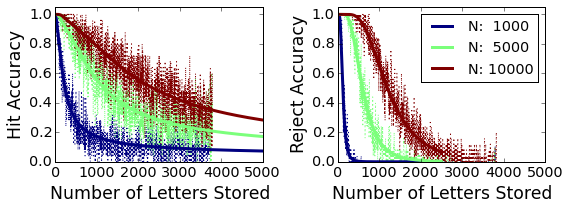

In [27]:

uN = unique(run_N)

figure(figsize=(8,3))
cm=get_cmap('jet', li_hit_mean.shape[1])

subplot(121)
for i in range(li_hit_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_hit_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), ':', color=cm(i), lw=1)
    

M = np.arange(1, 5000,10)
 #Phi(z) = 1/2[1 + erf(z/sqrt(2))]
for idxN,N in enumerate(test_N):
    p_correct = p_hit(M, N=N, D=D, reject_thresh=reject_thresh)
    plot(M, p_correct, color=cm(idxN),lw=3)

#title('Readout of most recent input');
xlabel('Number of Letters Stored');
ylabel('Hit Accuracy')
ylim([0, 1.05])
xlim([0, 5000])

subplot(122)
for i in range(li_cr_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(arange(li_cr_mean.shape[0]) * (1-p_null) / p_null, 
         np.convolve(li_cr_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), ':', color=cm(i), lw=1)
    

M = np.arange(1, 5000,10)
 #Phi(z) = 1/2[1 + erf(z/sqrt(2))]
for idxN,N in enumerate(test_N):
    p_correct = p_corr_rej(M*(1-p_null), N=N, D=D, reject_thresh=reject_thresh)
    plot(M*(1-p_null), p_correct, color=cm(idxN), lw=3, label="N: %5i" % test_N[idxN])

legend(loc='upper right');
xlabel('Number of Letters Stored');
ylabel('Reject Accuracy')
ylim([0, 1.05])
xlim([0, 5000])

plt.tight_layout()

savefig('figures/letter_capacity-input_sparsity-rt=' + str(reject_thresh) + '-pn=' + str(p_null) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/letter_capacity-input_sparsity-rt=' + str(reject_thresh) + '-pn=' + str(p_null) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [24]:
reject_thresh

0.5

In [28]:
N=1000
M=arange(N)+1
D=2


pcd2 = p_correct_l(M,N,D)
phit1 = p_hit(M,N,D-1)
pcr1 = p_corr_rej(M, N, D-1)



/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide


(0, 1.05)

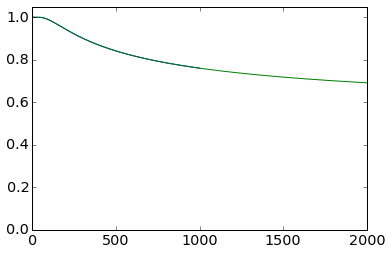

In [35]:
plot(M, pcd2)
plot(2*M, 0.5*phit1 + 0.5*pcr1)

ylim([0, 1.05])

In [93]:
N=2000
M=arange(N)+1
D=20

p_s = 1.0/D

pcd2 = p_correct_l(M,N,D)
phit1 = p_hit(M*(1-p_s),N,D-1, reject_thresh=0.5)
pcr1 = p_corr_rej(M*(1-p_s), N, D-1, reject_thresh=0.5)



/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


(0, 1.05)

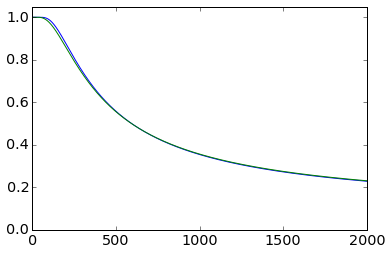

In [94]:
plot(M, pcd2)
plot(M, (1-p_s)*phit1 + p_s*pcr1)

ylim([0, 1.05])

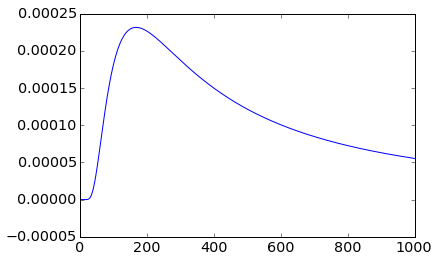

In [78]:
plot(M, (1-p_s)*phit1 + p_s*pcr1 - pcd2)